# Recommender Systems 2020/2021

## Practice 12 - Hybrid Recommenders

### Outline 
* Models with same model structure
* Models with different model structure
* Models with different loss functions
* CF-CBF Hybrids
* User-wise discrimination

## A few info about hybrids

### The way to go to achieve the best recommendation quality

There are many different types of hybrids, we will be covering only some of them.


## Administrative Code

Download the dataset, load the URM and ICM, and generate __TRAIN__, __VALIDATION__, and __TEST__ splits

In [1]:
from Data_manager.split_functions.split_train_validation_random_holdout import split_train_in_two_percentage_global_sample
from Data_manager.Movielens.Movielens10MReader import Movielens10MReader

data_reader = Movielens10MReader()
datasets_dict = data_reader.load_data()


Movielens10M: Verifying data consistency...
Movielens10M: Verifying data consistency... Passed!
DataReader: current dataset is: <class 'Data_manager.Dataset.Dataset'>
	Number of items: 10681
	Number of users: 69878
	Number of interactions in URM_all: 10000054
	Value range in URM_all: 0.50-5.00
	Interaction density: 1.34E-02
	Interactions per user:
		 Min: 2.00E+01
		 Avg: 1.43E+02
		 Max: 7.36E+03
	Interactions per item:
		 Min: 0.00E+00
		 Avg: 9.36E+02
		 Max: 3.49E+04
	Gini Index: 0.57

	ICM name: ICM_genres, Value range: 1.00 / 1.00, Num features: 20, feature occurrences: 21564, density 1.01E-01
	ICM name: ICM_tags, Value range: 1.00 / 69.00, Num features: 10217, feature occurrences: 108563, density 9.95E-04
	ICM name: ICM_all, Value range: 1.00 / 69.00, Num features: 10237, feature occurrences: 130127, density 1.19E-03




In [2]:
URM_all = datasets_dict.AVAILABLE_URM["URM_all"]
print(URM_all)

  (0, 0)	5.0
  (0, 1)	5.0
  (0, 2)	5.0
  (0, 3)	5.0
  (0, 4)	5.0
  (0, 5)	5.0
  (0, 6)	5.0
  (0, 7)	5.0
  (0, 8)	5.0
  (0, 9)	5.0
  (0, 10)	5.0
  (0, 11)	5.0
  (0, 12)	5.0
  (0, 13)	5.0
  (0, 14)	5.0
  (0, 15)	5.0
  (0, 16)	5.0
  (0, 17)	5.0
  (0, 18)	5.0
  (0, 19)	5.0
  (0, 20)	5.0
  (0, 21)	5.0
  (1, 16)	3.0
  (1, 22)	5.0
  (1, 23)	3.0
  :	:
  (69877, 463)	3.0
  (69877, 467)	1.0
  (69877, 468)	4.0
  (69877, 475)	2.0
  (69877, 481)	3.0
  (69877, 486)	4.0
  (69877, 505)	3.0
  (69877, 518)	1.0
  (69877, 537)	5.0
  (69877, 541)	2.0
  (69877, 1081)	2.0
  (69877, 1302)	4.0
  (69877, 1322)	2.0
  (69877, 1436)	4.0
  (69877, 1609)	1.0
  (69877, 1646)	3.0
  (69877, 1660)	2.0
  (69877, 1671)	2.0
  (69877, 2001)	4.0
  (69877, 2065)	1.0
  (69877, 2941)	1.0
  (69877, 3066)	1.0
  (69877, 3386)	3.0
  (69877, 3448)	1.0
  (69877, 5330)	1.0


In [3]:
datasets_dict.AVAILABLE_ICM

{'ICM_genres': <10681x20 sparse matrix of type '<class 'numpy.float64'>'
 	with 21564 stored elements in Compressed Sparse Row format>,
 'ICM_tags': <10681x10217 sparse matrix of type '<class 'numpy.float64'>'
 	with 108563 stored elements in Compressed Sparse Row format>,
 'ICM_all': <10681x10237 sparse matrix of type '<class 'numpy.float64'>'
 	with 130127 stored elements in Compressed Sparse Row format>}

In [4]:
ICM_all = datasets_dict.AVAILABLE_ICM["ICM_all"]
print(ICM_all)

  (0, 3)	1.0
  (0, 5)	1.0
  (0, 269)	1.0
  (0, 272)	1.0
  (0, 273)	1.0
  (0, 1530)	1.0
  (0, 1603)	1.0
  (1, 7)	1.0
  (1, 8)	1.0
  (1, 9)	1.0
  (1, 28)	1.0
  (1, 56)	6.0
  (1, 132)	2.0
  (1, 408)	1.0
  (1, 514)	1.0
  (1, 698)	7.0
  (1, 699)	7.0
  (1, 736)	1.0
  (1, 1543)	1.0
  (1, 1588)	3.0
  (1, 2384)	1.0
  (1, 2591)	1.0
  (1, 2654)	1.0
  (1, 4125)	1.0
  (1, 5153)	1.0
  :	:
  (10680, 809)	1.0
  (10680, 1059)	1.0
  (10680, 1568)	1.0
  (10680, 1587)	1.0
  (10680, 1588)	1.0
  (10680, 1752)	1.0
  (10680, 1810)	1.0
  (10680, 1844)	1.0
  (10680, 1845)	1.0
  (10680, 1936)	1.0
  (10680, 2072)	1.0
  (10680, 2122)	1.0
  (10680, 2543)	1.0
  (10680, 2831)	1.0
  (10680, 3164)	1.0
  (10680, 3444)	1.0
  (10680, 3454)	1.0
  (10680, 3818)	1.0
  (10680, 4021)	1.0
  (10680, 4059)	1.0
  (10680, 4060)	1.0
  (10680, 4134)	1.0
  (10680, 4135)	1.0
  (10680, 4291)	1.0
  (10680, 4365)	1.0


In [5]:
from Data_manager.split_functions.split_train_validation_random_holdout import split_train_in_two_percentage_global_sample

URM_train, URM_test = split_train_in_two_percentage_global_sample(URM_all, train_percentage = 0.8)
URM_train, URM_validation = split_train_in_two_percentage_global_sample(URM_train, train_percentage = 0.9)

URM_train, URM_validation, URM_test 

(<69878x10681 sparse matrix of type '<class 'numpy.float64'>'
 	with 7200739 stored elements in Compressed Sparse Row format>,
 <69878x10681 sparse matrix of type '<class 'numpy.float64'>'
 	with 799522 stored elements in Compressed Sparse Row format>,
 <69878x10681 sparse matrix of type '<class 'numpy.float64'>'
 	with 1999793 stored elements in Compressed Sparse Row format>)

In [6]:
from Base.Evaluation.Evaluator import EvaluatorHoldout

evaluator_validation = EvaluatorHoldout(URM_validation, cutoff_list=[5])
evaluator_test = EvaluatorHoldout(URM_test, cutoff_list=[5, 10])


## Models with the same model structure.

These type of hybrids share their model structure and merging them is almost a straight-forward process.

In this example, we are going to join one `ItemKNNCFRecommender` and one `P3AlphaRecommender`. Both use and learn a similarity matrix to provide recommendations. Notice that here we are merging a KNN-based with a Graph-based model.

First, let's fit `URM_train` in both recommenders.

In [7]:
from KNN.ItemKNNCFRecommender import ItemKNNCFRecommender

itemKNNCF = ItemKNNCFRecommender(URM_train)
itemKNNCF.fit()

ItemKNNCFRecommender: URM Detected 51 (0.48 %) cold items.
Similarity column 10681 ( 100 % ), 1031.19 column/sec, elapsed time 0.17 min


In [8]:
from GraphBased.P3alphaRecommender import P3alphaRecommender

P3alpha = P3alphaRecommender(URM_train)
P3alpha.fit()

P3alphaRecommender: URM Detected 51 (0.48 %) cold items.


Now that we have both models fit with `URM_train` how can we merge them?


Well, we could take the advantage that they have the same underlying structure, i.e. a similarity matrix

In [9]:
print(itemKNNCF.W_sparse)
itemKNNCF.W_sparse

  (0, 310)	0.16683605
  (0, 325)	0.12676474
  (0, 334)	0.12219221
  (0, 341)	0.10018349
  (0, 344)	0.19398944
  (0, 350)	0.21513033
  (0, 351)	0.17883904
  (0, 354)	0.21253823
  (0, 1002)	0.16986045
  (0, 1113)	0.21151266
  (0, 1114)	0.119368665
  (0, 1116)	0.11668418
  (0, 1420)	0.21915153
  (0, 1423)	0.18625782
  (0, 1535)	0.196528
  (0, 1567)	0.16026807
  (0, 1574)	0.18781635
  (0, 1581)	0.16688247
  (0, 1588)	0.15299504
  (0, 1589)	0.18678235
  (0, 1591)	0.14647907
  (0, 1593)	0.18394682
  (0, 1987)	0.16455108
  (0, 1997)	0.17469533
  (0, 1998)	0.17995258
  :	:
  (10673, 10454)	0.105481416
  (10673, 10456)	0.110170044
  (10673, 10532)	0.07151807
  (10673, 10545)	0.08376295
  (10673, 10565)	0.08455887
  (10673, 10575)	0.09839257
  (10673, 10618)	0.08898174
  (10673, 10633)	0.074226804
  (10673, 10658)	0.105481416
  (10673, 10666)	0.16577074
  (10675, 4404)	0.13008967
  (10675, 4546)	0.09112901
  (10675, 6307)	0.10083404
  (10675, 7129)	0.09938316
  (10675, 8303)	0.06505215
  (10675,

<10681x10681 sparse matrix of type '<class 'numpy.float32'>'
	with 531358 stored elements in Compressed Sparse Row format>

In [10]:
print(P3alpha.W_sparse)
P3alpha.W_sparse

  (0, 2)	0.0037714113
  (0, 10)	0.0022185664
  (0, 12)	0.0029647208
  (0, 13)	0.0024064989
  (0, 15)	0.0021872083
  (0, 17)	0.0034567656
  (0, 73)	0.0036162455
  (0, 82)	0.0047459328
  (0, 83)	0.0048709777
  (0, 85)	0.0055546267
  (0, 86)	0.0030392804
  (0, 87)	0.002480492
  (0, 88)	0.003777373
  (0, 89)	0.0021177568
  (0, 90)	0.003932561
  (0, 92)	0.0042877323
  (0, 95)	0.004196557
  (0, 306)	0.0021963164
  (0, 312)	0.0025065884
  (0, 315)	0.0024455832
  (0, 321)	0.0020809602
  (0, 324)	0.0028818918
  (0, 326)	0.0021028768
  (0, 327)	0.003361771
  (0, 331)	0.0023835287
  :	:
  (10676, 2969)	0.005076142
  (10676, 3061)	0.00571066
  (10676, 3126)	0.005076142
  (10676, 3343)	0.005076142
  (10676, 3353)	0.0044416245
  (10676, 3672)	0.005076142
  (10676, 3705)	0.00571066
  (10676, 3725)	0.00571066
  (10676, 3753)	0.005076142
  (10676, 3757)	0.00571066
  (10676, 3778)	0.005076142
  (10676, 4169)	0.0044416245
  (10676, 4524)	0.005076142
  (10676, 4608)	0.00571066
  (10676, 4661)	0.00571066
 

<10681x10681 sparse matrix of type '<class 'numpy.float32'>'
	with 189466 stored elements in Compressed Sparse Row format>

🤔 So, if we do 1+1=2... maybe we can do exactly this 🤣

In [11]:
new_similarity = itemKNNCF.W_sparse + P3alpha.W_sparse
new_similarity, print(new_similarity)

  (0, 2)	0.0037714113
  (0, 10)	0.0022185664
  (0, 12)	0.0029647208
  (0, 13)	0.0024064989
  (0, 15)	0.0021872083
  (0, 17)	0.0034567656
  (0, 73)	0.0036162455
  (0, 82)	0.0047459328
  (0, 83)	0.0048709777
  (0, 85)	0.0055546267
  (0, 86)	0.0030392804
  (0, 87)	0.002480492
  (0, 88)	0.003777373
  (0, 89)	0.0021177568
  (0, 90)	0.003932561
  (0, 92)	0.0042877323
  (0, 95)	0.004196557
  (0, 306)	0.0021963164
  (0, 310)	0.16683605
  (0, 312)	0.0025065884
  (0, 315)	0.0024455832
  (0, 321)	0.0020809602
  (0, 324)	0.0028818918
  (0, 325)	0.12676474
  (0, 326)	0.0021028768
  :	:
  (10676, 3061)	0.00571066
  (10676, 3126)	0.005076142
  (10676, 3343)	0.005076142
  (10676, 3353)	0.0044416245
  (10676, 3672)	0.005076142
  (10676, 3705)	0.00571066
  (10676, 3725)	0.00571066
  (10676, 3753)	0.005076142
  (10676, 3757)	0.00571066
  (10676, 3778)	0.005076142
  (10676, 4169)	0.0044416245
  (10676, 4524)	0.005076142
  (10676, 4608)	0.00571066
  (10676, 4661)	0.08411863
  (10676, 4689)	0.00571066
  (10

(<10681x10681 sparse matrix of type '<class 'numpy.float32'>'
 	with 701649 stored elements in Compressed Sparse Row format>,
 None)

However, things might not be so simple, specially if we want to control or tune the *weights* ($\lambda$)  of each similarity. 

Imagine that the values of one similarity are orders of magnitude higher than the other, then the smaller values would get absorbed by the bigger ones. 

Or, if the values are the same but we discovered that a factor of 2/3 of P3Alpha similarity is just right (any ideas how we discovered this?)

In [12]:
lambda_weight = 2/3
new_similarity = (1 - lambda_weight) * itemKNNCF.W_sparse + (lambda_weight) * P3alpha.W_sparse
new_similarity, print(new_similarity)

  (0, 2)	0.0025142743
  (0, 10)	0.0014790443
  (0, 12)	0.0019764807
  (0, 13)	0.0016043326
  (0, 15)	0.0014581389
  (0, 17)	0.0023045104
  (0, 73)	0.0024108305
  (0, 82)	0.0031639552
  (0, 83)	0.0032473186
  (0, 85)	0.0037030845
  (0, 86)	0.002026187
  (0, 87)	0.0016536614
  (0, 88)	0.0025182487
  (0, 89)	0.0014118379
  (0, 90)	0.0026217073
  (0, 92)	0.0028584884
  (0, 95)	0.002797705
  (0, 306)	0.0014642109
  (0, 310)	0.05561202
  (0, 312)	0.0016710589
  (0, 315)	0.0016303889
  (0, 321)	0.0013873068
  (0, 324)	0.0019212612
  (0, 325)	0.042254917
  (0, 326)	0.0014019179
  :	:
  (10676, 3061)	0.0038071068
  (10676, 3126)	0.0033840947
  (10676, 3343)	0.0033840947
  (10676, 3353)	0.002961083
  (10676, 3672)	0.0033840947
  (10676, 3705)	0.0038071068
  (10676, 3725)	0.0038071068
  (10676, 3753)	0.0033840947
  (10676, 3757)	0.0038071068
  (10676, 3778)	0.0033840947
  (10676, 4169)	0.002961083
  (10676, 4524)	0.0033840947
  (10676, 4608)	0.0038071068
  (10676, 4661)	0.029943096
  (10676, 4689

(<10681x10681 sparse matrix of type '<class 'numpy.float32'>'
 	with 701649 stored elements in Compressed Sparse Row format>,
 None)

Moreover, we can apply the same optimizations to this similarity as we applied to the others (for example: topK neighbors)

Let's put all this in a recommender class.

In [15]:
from Base.Recommender_utils import check_matrix, similarityMatrixTopK
from Base.BaseSimilarityMatrixRecommender import BaseItemSimilarityMatrixRecommender


class SimilarityHybridRecommender(BaseItemSimilarityMatrixRecommender):
    """ SimilarityHybridRecommender
    Hybrid of two similarities S = S1*alpha + S2*(1-alpha)

    """

    RECOMMENDER_NAME = "SimilarityHybridRecommender"


    def __init__(self, URM_train, similarity_1, similarity_2, sparse_weights=True):
        super(SimilarityHybridRecommender, self).__init__(URM_train)

        if similarity_1.shape != similarity_2.shape:
            raise ValueError("ItemKNNSimilarityHybridRecommender: similarities have different size, S1 is {}, S2 is {}".format(
                similarity_1.shape, similarity_2.shape
            ))

        # CSR is faster during evaluation
        self.similarity_1 = check_matrix(similarity_1.copy(), 'csr')
        self.similarity_2 = check_matrix(similarity_2.copy(), 'csr')


    def fit(self, topK=100, alpha = 0.5):

        self.topK = topK
        self.alpha = alpha

        W = self.similarity_1*self.alpha + self.similarity_2*(1 - self.alpha)
        self.W_sparse = similarityMatrixTopK(W, k=self.topK).tocsr()
       

In [16]:
hybridrecommender = SimilarityHybridRecommender(URM_train, itemKNNCF.W_sparse, P3alpha.W_sparse)
hybridrecommender.fit(alpha = 0.66)

SimilarityHybridRecommender: URM Detected 51 (0.48 %) cold items.


In [17]:
evaluator_test.evaluateRecommender(hybridrecommender)

EvaluatorHoldout: Processed 37000 ( 53.00% ) in 30.03 sec. Users per second: 1232
EvaluatorHoldout: Processed 69815 ( 100.00% ) in 53.60 sec. Users per second: 1303


({5: {'ROC_AUC': 0.4270214137363035,
   'PRECISION': 0.3090052281029336,
   'PRECISION_RECALL_MIN_DEN': 0.3159068013082983,
   'RECALL': 0.10271185329381975,
   'MAP': 0.22958406741631762,
   'MRR': 0.5081322065458569,
   'NDCG': 0.1458522273461095,
   'F1': 0.1541762588438581,
   'HIT_RATE': 1.545026140514216,
   'ARHR': 0.7594105851177704,
   'NOVELTY': 0.004416506276642869,
   'AVERAGE_POPULARITY': 0.4892814970122397,
   'DIVERSITY_MEAN_INTER_LIST': 0.9642144088941164,
   'DIVERSITY_HERFINDAHL': 0.9928401195804164,
   'COVERAGE_ITEM': 0.228443029678869,
   'COVERAGE_ITEM_CORRECT': 0.12817151952064412,
   'COVERAGE_USER': 0.9990984286900025,
   'COVERAGE_USER_CORRECT': 0.72749649388935,
   'DIVERSITY_GINI': 0.021007878593414752,
   'SHANNON_ENTROPY': 8.019100122493343},
  10: {'ROC_AUC': 0.490107994597969,
   'PRECISION': 0.2685067678865755,
   'PRECISION_RECALL_MIN_DEN': 0.3071828778779353,
   'RECALL': 0.17009637682005196,
   'MAP': 0.188622406762682,
   'MRR': 0.521511739074567,
 

### 🚨IMPORTANT🚨 In this case the alpha coefficient is too a parameter to be tuned

## Models with different structure

We just saw the case where models had compatible structure (ItemKNN with P3Alpha) but there are certain cases where we want to combine recommenders with different underlying structures. For instance ItemKNN and UserKNN or ItemKNN with PureSVD.

In these cases, what can we do? I hope you remember Bob. We are going to use them as an example.

<img src="images/bob_example.jpeg" style="margin: 0 auto;width: 250px;" alt="Bob Image">

Again, bob is `user_id` 42. Remember how we computed recommendations for a user? Basically we compute the item scores and pick those that have the highest score.

In [18]:
user_id = 42

In [19]:
from MatrixFactorization.PureSVDRecommender import PureSVDRecommender

pureSVD = PureSVDRecommender(URM_train)
pureSVD.fit()


PureSVDRecommender: URM Detected 51 (0.48 %) cold items.
PureSVDRecommender: Computing SVD decomposition...
PureSVDRecommender: Computing SVD decomposition... Done!


Ok, now that we have fit PureSVD, how do we merge the latent factors with the similarity matrix of an ItemKNN?

We don't. Instead, why don't we go a level up in the abstraction and take a look to how we provide recommendations?

In [20]:
item_scores_itemknn = itemKNNCF._compute_item_score(user_id).flatten()
item_scores_itemknn, item_scores_itemknn.shape 

(array([0.       , 4.636806 , 3.5966833, ..., 0.       , 0.       ,
        0.       ], dtype=float32),
 (10681,))

In [21]:
item_scores_puresvd = pureSVD._compute_item_score(user_id)
item_scores_puresvd, item_scores_puresvd.shape 

(array([-0.08680601,  0.39258292,  0.45441326, ...,  0.        ,
         0.        ,  0.        ], dtype=float32),
 (10681,))

As you can see, we provide a score for every item in the dataset in both recommenders. 

Remember that after calculating these scores, we sort them and take the n-most relevant ones.

In any case, what would happen if we somehow merge those scores as we did with the similarity matrices? 

(Spoiler Alert! We will need $\lambda$ again

In [22]:
lambda_weight = 0.66

new_item_scores = (lambda_weight) * item_scores_itemknn + (1 - lambda_weight) * item_scores_puresvd
new_item_scores, new_item_scores.shape

(array([-0.02951404,  3.1937702 ,  2.5283115 , ...,  0.        ,
         0.        ,  0.        ], dtype=float32),
 (10681,))

Let's put all this in a recommender class again 😎

In [23]:
class ScoresHybridRecommender(BaseItemSimilarityMatrixRecommender):
    """ ScoresHybridRecommender
    Hybrid of two prediction scores R = R1*alpha + R2*(1-alpha)

    """

    RECOMMENDER_NAME = "ScoresHybridRecommender"


    def __init__(self, URM_train, recommender_1, recommender_2):
        super(ScoresHybridRecommender, self).__init__(URM_train)

        self.URM_train = check_matrix(URM_train.copy(), 'csr')
        self.recommender_1 = recommender_1
        self.recommender_2 = recommender_2
        
        
    def fit(self, alpha = 0.5):

        self.alpha = alpha      


    def _compute_item_score(self, user_id_array, items_to_compute):
        
        item_weights_1 = self.recommender_1._compute_item_score(user_id_array)
        item_weights_2 = self.recommender_2._compute_item_score(user_id_array)

        item_weights = item_weights_1*self.alpha + item_weights_2*(1-self.alpha)

        return item_weights


In [24]:
scoreshybridrecommender = ScoresHybridRecommender(URM_train, itemKNNCF, pureSVD)
scoreshybridrecommender.fit(alpha = 0.5)


ScoresHybridRecommender: URM Detected 51 (0.48 %) cold items.


In [25]:
evaluator_test.evaluateRecommender(scoreshybridrecommender)

EvaluatorHoldout: Processed 33000 ( 47.27% ) in 30.86 sec. Users per second: 1069
EvaluatorHoldout: Processed 66000 ( 94.54% ) in 1.03 min. Users per second: 1073
EvaluatorHoldout: Processed 69815 ( 100.00% ) in 1.08 min. Users per second: 1072


({5: {'ROC_AUC': 0.4334145002267873,
   'PRECISION': 0.31712382725784416,
   'PRECISION_RECALL_MIN_DEN': 0.324355081286335,
   'RECALL': 0.10612677628173309,
   'MAP': 0.2368619685359414,
   'MRR': 0.5187662632194485,
   'NDCG': 0.14916805562848864,
   'F1': 0.15903263545306753,
   'HIT_RATE': 1.585619136288763,
   'ARHR': 0.7793542457446605,
   'NOVELTY': 0.004449649356540308,
   'AVERAGE_POPULARITY': 0.46063973035510714,
   'DIVERSITY_MEAN_INTER_LIST': 0.9704823579054837,
   'DIVERSITY_HERFINDAHL': 0.9940936914268093,
   'COVERAGE_ITEM': 0.2154292669225728,
   'COVERAGE_ITEM_CORRECT': 0.12349030989607715,
   'COVERAGE_USER': 0.9990984286900025,
   'COVERAGE_USER_CORRECT': 0.737313603709322,
   'DIVERSITY_GINI': 0.021908119625485188,
   'SHANNON_ENTROPY': 8.170515620104615},
  10: {'ROC_AUC': 0.4965444138647584,
   'PRECISION': 0.2749008092816878,
   'PRECISION_RECALL_MIN_DEN': 0.31450034615293326,
   'RECALL': 0.17419815532022057,
   'MAP': 0.19490928433993904,
   'MRR': 0.5317380287

## Models with different loss function

What happens if we have two models, for instance SLIMBPR and MFMSE, i.e., a model optimized for BPR (ranking) and another for rating prediction (MSE)? 

For instance, think about FunkSVD (optimized for MSE) and a SLIMBPRRecommender (optimized for BPR).

First, let's train a FunkSVD and a SLIMBPR recommender.

In [26]:
from MatrixFactorization.Cython.MatrixFactorization_Cython import MatrixFactorization_FunkSVD_Cython

funk_svd_recommender = MatrixFactorization_FunkSVD_Cython(URM_train)
funk_svd_recommender.fit(epochs=100)

MatrixFactorization_FunkSVD_Cython_Recommender: URM Detected 51 (0.48 %) cold items.
FUNK_SVD: Processed 7200000 ( 99.99% ) in 11.73 seconds. MSE loss 2.04E+00. Sample per second: 613761
FUNK_SVD: Epoch 1 of 100. Elapsed time 10.93 sec
FUNK_SVD: Processed 7200000 ( 99.99% ) in 12.12 seconds. MSE loss 1.13E+00. Sample per second: 594046
FUNK_SVD: Epoch 2 of 100. Elapsed time 22.32 sec
FUNK_SVD: Processed 7200000 ( 99.99% ) in 11.44 seconds. MSE loss 1.13E+00. Sample per second: 629152
FUNK_SVD: Epoch 3 of 100. Elapsed time 33.64 sec
FUNK_SVD: Processed 7200000 ( 99.99% ) in 11.08 seconds. MSE loss 1.13E+00. Sample per second: 649650
FUNK_SVD: Epoch 4 of 100. Elapsed time 44.28 sec
FUNK_SVD: Processed 7200000 ( 99.99% ) in 11.13 seconds. MSE loss 1.12E+00. Sample per second: 646663
FUNK_SVD: Epoch 5 of 100. Elapsed time 55.33 sec
FUNK_SVD: Processed 7200000 ( 99.99% ) in 10.85 seconds. MSE loss 1.12E+00. Sample per second: 663523
FUNK_SVD: Epoch 6 of 100. Elapsed time 1.10 min
FUNK_SVD: 

FUNK_SVD: Processed 7200000 ( 99.99% ) in 12.04 seconds. MSE loss 1.05E+00. Sample per second: 598006
FUNK_SVD: Epoch 55 of 100. Elapsed time 9.80 min
FUNK_SVD: Processed 7200000 ( 99.99% ) in 11.45 seconds. MSE loss 1.05E+00. Sample per second: 629007
FUNK_SVD: Epoch 56 of 100. Elapsed time 9.99 min
FUNK_SVD: Processed 7200000 ( 99.99% ) in 12.02 seconds. MSE loss 1.05E+00. Sample per second: 598803
FUNK_SVD: Epoch 57 of 100. Elapsed time 10.19 min
FUNK_SVD: Processed 7200000 ( 99.99% ) in 10.76 seconds. MSE loss 1.05E+00. Sample per second: 669216
FUNK_SVD: Epoch 58 of 100. Elapsed time 10.37 min
FUNK_SVD: Processed 7200000 ( 99.99% ) in 11.65 seconds. MSE loss 1.05E+00. Sample per second: 618104
FUNK_SVD: Epoch 59 of 100. Elapsed time 10.55 min
FUNK_SVD: Processed 7200000 ( 99.99% ) in 12.37 seconds. MSE loss 1.05E+00. Sample per second: 582178
FUNK_SVD: Epoch 60 of 100. Elapsed time 10.74 min
FUNK_SVD: Processed 7200000 ( 99.99% ) in 10.92 seconds. MSE loss 1.05E+00. Sample per sec

In [27]:
from SLIM_BPR.Cython.SLIM_BPR_Cython import SLIM_BPR_Cython

slim_bpr_recommender = SLIM_BPR_Cython(URM_train)
slim_bpr_recommender.fit(epochs=100)

SLIM_BPR_Recommender: URM Detected 51 (0.48 %) cold items.
Unable to read memory status: list index out of range
SLIM_BPR_Recommender: Automatic selection of fastest train mode. Unable to get current RAM status, you may be using a non-Linux operating system. Using dense matrix.
Processed 69878 ( 100.00% ) in 0.91 seconds. BPR loss is 5.94E-04. Sample per second: 76467
SLIM_BPR_Recommender: Epoch 1 of 100. Elapsed time 0.58 sec
Processed 69878 ( 100.00% ) in 1.52 seconds. BPR loss is 1.93E-03. Sample per second: 45925
SLIM_BPR_Recommender: Epoch 2 of 100. Elapsed time 1.18 sec
Processed 69878 ( 100.00% ) in 1.12 seconds. BPR loss is 3.24E-03. Sample per second: 62524
SLIM_BPR_Recommender: Epoch 3 of 100. Elapsed time 1.78 sec
Processed 69878 ( 100.00% ) in 0.72 seconds. BPR loss is 4.56E-03. Sample per second: 96423
SLIM_BPR_Recommender: Epoch 4 of 100. Elapsed time 2.39 sec
Processed 69878 ( 100.00% ) in 1.33 seconds. BPR loss is 5.89E-03. Sample per second: 52583
SLIM_BPR_Recommender:

SLIM_BPR_Recommender: Epoch 52 of 100. Elapsed time 31.07 sec
Processed 69878 ( 100.00% ) in 0.99 seconds. BPR loss is 6.69E-02. Sample per second: 70396
SLIM_BPR_Recommender: Epoch 53 of 100. Elapsed time 31.66 sec
Processed 69878 ( 100.00% ) in 1.57 seconds. BPR loss is 6.74E-02. Sample per second: 44370
SLIM_BPR_Recommender: Epoch 54 of 100. Elapsed time 32.24 sec
Processed 69878 ( 100.00% ) in 1.15 seconds. BPR loss is 6.97E-02. Sample per second: 60563
SLIM_BPR_Recommender: Epoch 55 of 100. Elapsed time 32.82 sec
Processed 69878 ( 100.00% ) in 0.73 seconds. BPR loss is 7.07E-02. Sample per second: 95796
SLIM_BPR_Recommender: Epoch 56 of 100. Elapsed time 33.39 sec
Processed 69878 ( 100.00% ) in 1.31 seconds. BPR loss is 7.25E-02. Sample per second: 53246
SLIM_BPR_Recommender: Epoch 57 of 100. Elapsed time 33.98 sec
Processed 69878 ( 100.00% ) in 0.89 seconds. BPR loss is 7.15E-02. Sample per second: 78503
SLIM_BPR_Recommender: Epoch 58 of 100. Elapsed time 34.55 sec
Processed 6987

Both of these recommenders have the `_compute_item_score` function. However, the scores might be totally different.

Let's see

In [28]:
funk_svd_score = funk_svd_recommender._compute_item_score(user_id)
funk_svd_score

array([3.4511825 , 3.360555  , 2.94252733, ..., 3.59655592, 3.61788779,
       3.52799269])

In [29]:
slim_bpr_score = slim_bpr_recommender._compute_item_score(user_id).flatten()
slim_bpr_score

array([0.       , 0.4702121, 0.5542077, ..., 0.       , 0.       ,
       0.       ], dtype=float32)

Here is where things get complicated. You see, the scores that each function computes have completely different meanings, we cannot just join them as if they are the same thing. 

Let's calculate some percentiles and do some visualizations on the scores.

In [30]:
import seaborn as sns
import numpy as np
from numpy import linalg as LA
import matplotlib.pyplot as plt

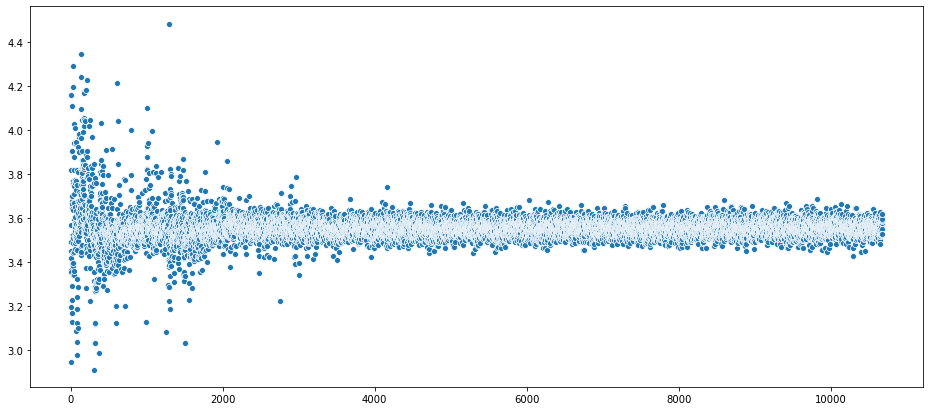

In [31]:
_ = plt.figure(figsize=(16,7))
ax = sns.scatterplot(data=funk_svd_score)

In [32]:
np.percentile(funk_svd_score, [0, 25, 50, 75, 100])


array([2.90979064, 3.5282713 , 3.55435543, 3.58013343, 4.48465597])

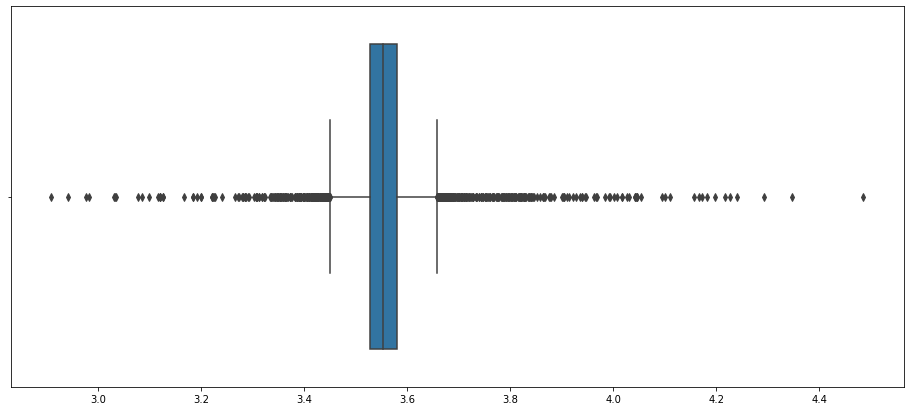

In [33]:
_ = plt.figure(figsize=(16,7))
ax = sns.boxplot(x=funk_svd_score)

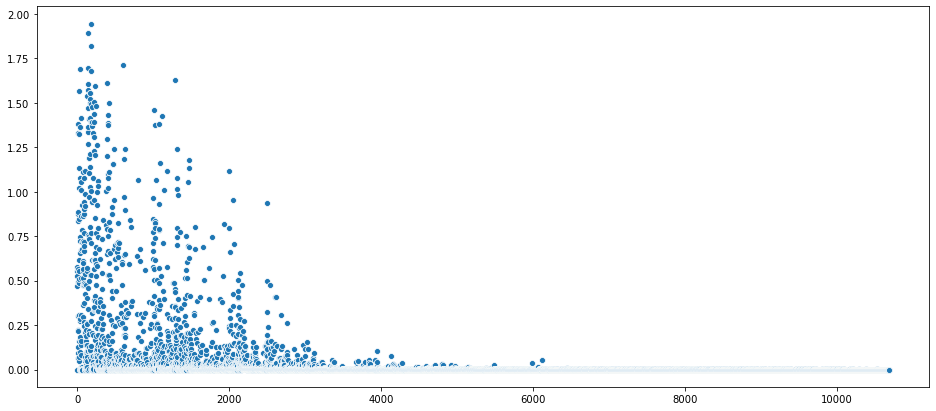

In [34]:
_ = plt.figure(figsize=(16,7))
ax = sns.scatterplot(data=slim_bpr_score)

In [35]:
np.percentile(slim_bpr_score, [0, 25, 50, 75, 100])


array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 5.67586394e-04,
       1.94428420e+00])

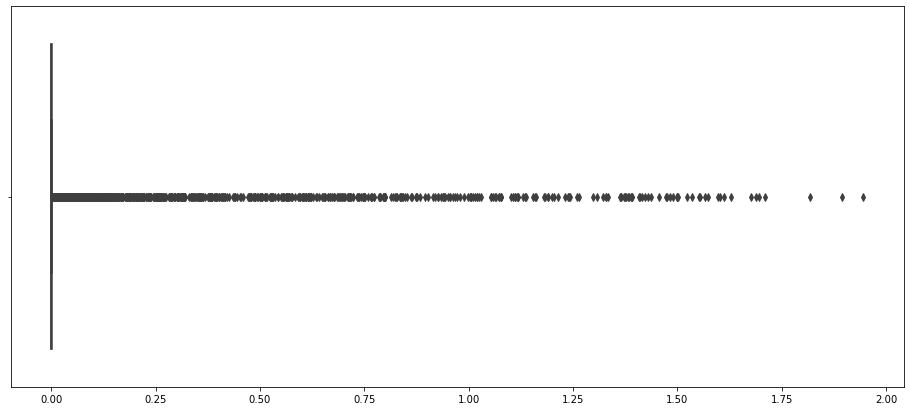

In [36]:
_ = plt.figure(figsize=(16,7))
ax = sns.boxplot(x=slim_bpr_score)

As you can see from the plots and the percentiles, the values held in each score array is totally different from one to another. 

As such, we need a way to _normalize_ these scores to be able to merge them into one.

[3.4511825  3.360555   2.94252733 ... 3.59655592 3.61788779 3.52799269] 4.484655973845666 367.53939730606237 4.484655973845666 2.909790638413597


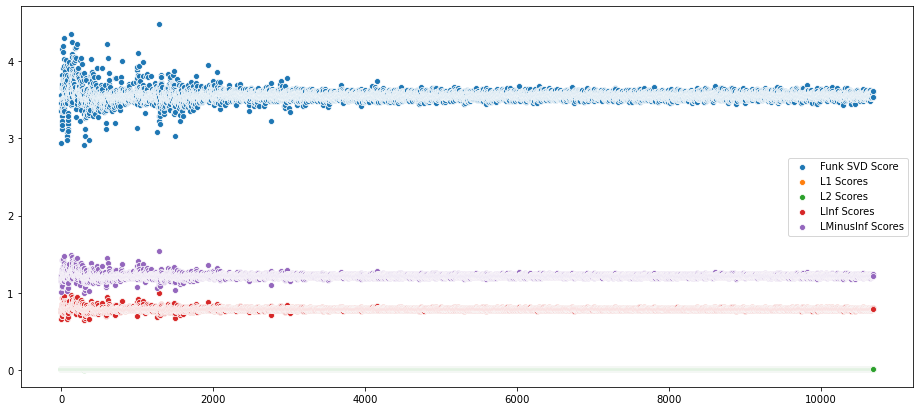

In [37]:
l1_funk_svd = LA.norm([funk_svd_score], 1)
l1_funk_svd_scores = funk_svd_score / l1_funk_svd

l2_funk_svd = LA.norm([funk_svd_score], 2)
l2_funk_svd_scores = funk_svd_score / l2_funk_svd

linf_funk_svd = LA.norm(funk_svd_score, np.inf)
linf_funk_svd_scores = funk_svd_score / linf_funk_svd

lminusinf_funk_svd = LA.norm(funk_svd_score, -np.inf)
lminusinf_funk_svd_scores = funk_svd_score / lminusinf_funk_svd

print(funk_svd_score, l1_funk_svd, l2_funk_svd, linf_funk_svd, lminusinf_funk_svd)

_ = plt.figure(figsize=(16,7))
ax = sns.scatterplot(data=funk_svd_score)
ax = sns.scatterplot(data=l1_funk_svd_scores) 
ax = sns.scatterplot(data=l2_funk_svd_scores) 
ax = sns.scatterplot(data=linf_funk_svd_scores) 
ax = sns.scatterplot(data=lminusinf_funk_svd_scores) 
ax.legend(["Funk SVD Score", "L1 Scores", "L2 Scores", "LInf Scores", "LMinusInf Scores"])

Similarly, we can do the same with SLIM BPR scores

[0.        0.4702121 0.5542077 ... 0.        0.        0.       ] 354.8052 16.6035 1.9442842 0.0


/Users/fernandobperezm/miniconda3/envs/RecSysFramework/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()
/Users/fernandobperezm/miniconda3/envs/RecSysFramework/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()


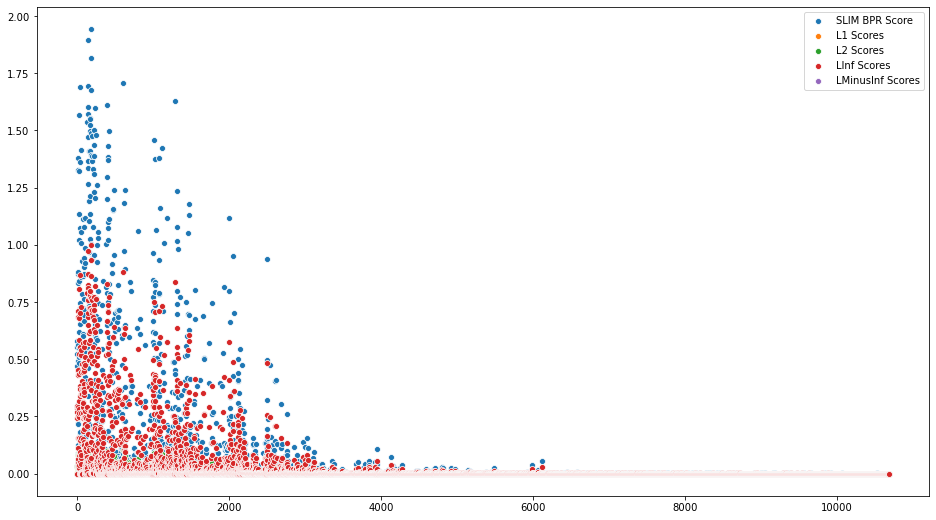

In [38]:
l1_slim_bpr = LA.norm(slim_bpr_score, 1)
l1_slim_bpr_scores = slim_bpr_score / l1_slim_bpr

l2_slim_bpr = LA.norm(slim_bpr_score, 2)
l2_slim_bpr_scores = slim_bpr_score / l2_slim_bpr

linf_slim_bpr = LA.norm(slim_bpr_score, np.inf)
linf_slim_bpr_scores = slim_bpr_score / linf_slim_bpr

lminusinf_slim_bpr = LA.norm(slim_bpr_score, -np.inf)
lminusinf_slim_bpr_scores = slim_bpr_score / lminusinf_slim_bpr

print(slim_bpr_score, l1_slim_bpr, l2_slim_bpr, linf_slim_bpr, lminusinf_slim_bpr)

_ = plt.figure(figsize=(16,9))
ax = sns.scatterplot(data=slim_bpr_score)
ax = sns.scatterplot(data=l1_slim_bpr_scores) 
ax = sns.scatterplot(data=l2_slim_bpr_scores) 
ax = sns.scatterplot(data=linf_slim_bpr_scores) 
ax = sns.scatterplot(data=lminusinf_slim_bpr_scores) 
ax.legend(["SLIM BPR Score", "L1 Scores", "L2 Scores", "LInf Scores", "LMinusInf Scores"])

Now that we have *normalized* the different item score vectors, we can merge the models.

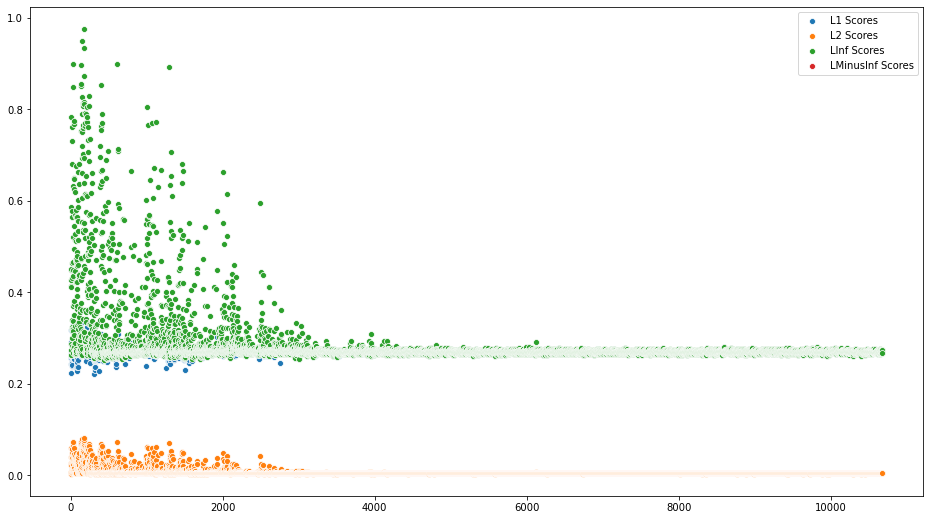

In [39]:
lambda_weights = 0.66

l1_new_scores = lambda_weights * l1_slim_bpr_scores + (1 - lambda_weights) * l1_funk_svd_scores
l2_new_scores = lambda_weights * l2_slim_bpr_scores + (1 - lambda_weights) * l2_funk_svd_scores
linf_new_scores = lambda_weights * linf_slim_bpr_scores + (1 - lambda_weights) * linf_funk_svd_scores
lminusinf_new_scores = lambda_weights * lminusinf_slim_bpr_scores + (1 - lambda_weights) * lminusinf_funk_svd_scores

_ = plt.figure(figsize=(16,9))
ax = sns.scatterplot(data=l1_new_scores)
ax = sns.scatterplot(data=l2_new_scores) 
ax = sns.scatterplot(data=linf_new_scores) 
ax = sns.scatterplot(data=lminusinf_new_scores) 
ax.legend(["L1 Scores", "L2 Scores", "LInf Scores", "LMinusInf Scores"])

Now, we have everything to create our hybrid.

In [40]:
class DifferentLossScoresHybridRecommender(BaseItemSimilarityMatrixRecommender):
    """ ScoresHybridRecommender
    Hybrid of two prediction scores R = R1/norm*alpha + R2/norm*(1-alpha) where R1 and R2 come from
    algorithms trained on different loss functions.

    """

    RECOMMENDER_NAME = "DifferentLossScoresHybridRecommender"


    def __init__(self, URM_train, recommender_1, recommender_2, norm):
        super(DifferentLossScoresHybridRecommender, self).__init__(URM_train)

        self.URM_train = check_matrix(URM_train.copy(), 'csr')
        self.recommender_1 = recommender_1
        self.recommender_2 = recommender_2
        self.norm = norm
        
        
    def fit(self, alpha = 0.5):

        self.alpha = alpha      


    def _compute_item_score(self, user_id_array, items_to_compute):
        
        item_weights_1 = self.recommender_1._compute_item_score(user_id_array)
        item_weights_2 = self.recommender_2._compute_item_score(user_id_array)

        norm_item_weights_1 = LA.norm(item_weights_1, self.norm)
        norm_item_weights_2 = LA.norm(item_weights_2, self.norm)
        
        
        if norm_item_weights_1 == 0:
            raise ValueError("Norm {} of item weights for recommender 1 is zero. Avoiding division by zero".format(self.norm))
        
        if norm_item_weights_2 == 0:
            raise ValueError("Norm {} of item weights for recommender 2 is zero. Avoiding division by zero".format(self.norm))
        
        item_weights = item_weights_1 / norm_item_weights_1 * self.alpha + item_weights_2 / norm_item_weights_2 * (1-self.alpha)

        return item_weights



In [41]:
difflossscoreshybridrecommender = DifferentLossScoresHybridRecommender(URM_train, funk_svd_recommender, slim_bpr_recommender, 2)
difflossscoreshybridrecommender.fit(alpha = 0.66)


DifferentLossScoresHybridRecommender: URM Detected 51 (0.48 %) cold items.


In [42]:
evaluator_test.evaluateRecommender(difflossscoreshybridrecommender)

EvaluatorHoldout: Processed 11000 ( 15.76% ) in 32.50 sec. Users per second: 338
EvaluatorHoldout: Processed 21000 ( 30.08% ) in 1.04 min. Users per second: 335
EvaluatorHoldout: Processed 31000 ( 44.40% ) in 1.55 min. Users per second: 334
EvaluatorHoldout: Processed 41000 ( 58.73% ) in 2.06 min. Users per second: 331
EvaluatorHoldout: Processed 51000 ( 73.05% ) in 2.57 min. Users per second: 330
EvaluatorHoldout: Processed 61000 ( 87.37% ) in 3.11 min. Users per second: 327
EvaluatorHoldout: Processed 69815 ( 100.00% ) in 3.59 min. Users per second: 324


({5: {'ROC_AUC': 0.4050884480412531,
   'PRECISION': 0.27145169376216544,
   'PRECISION_RECALL_MIN_DEN': 0.27838072047561563,
   'RECALL': 0.0963577564740878,
   'MAP': 0.20046407569215668,
   'MRR': 0.4737463295853114,
   'NDCG': 0.13607511897676353,
   'F1': 0.14222840759100905,
   'HIT_RATE': 1.3572584688104277,
   'ARHR': 0.6832748454247788,
   'NOVELTY': 0.004013207931623173,
   'AVERAGE_POPULARITY': 0.7781030520912873,
   'DIVERSITY_MEAN_INTER_LIST': 0.7988495864788951,
   'DIVERSITY_HERFINDAHL': 0.9597676288202752,
   'COVERAGE_ITEM': 0.0315513528695815,
   'COVERAGE_ITEM_CORRECT': 0.021439940080516806,
   'COVERAGE_USER': 0.9990984286900025,
   'COVERAGE_USER_CORRECT': 0.6774521308566358,
   'DIVERSITY_GINI': 0.0027384454941988805,
   'SHANNON_ENTROPY': 5.22437826559091},
  10: {'ROC_AUC': 0.466757055210539,
   'PRECISION': 0.2339067535630365,
   'PRECISION_RECALL_MIN_DEN': 0.2720487706171466,
   'RECALL': 0.15731693507698938,
   'MAP': 0.1636961090112944,
   'MRR': 0.487955276

In [43]:
difflossscoreshybridrecommender.norm = 1
evaluator_test.evaluateRecommender(difflossscoreshybridrecommender)

EvaluatorHoldout: Processed 28000 ( 40.11% ) in 30.82 sec. Users per second: 908
EvaluatorHoldout: Processed 62000 ( 88.81% ) in 1.02 min. Users per second: 1011
EvaluatorHoldout: Processed 69815 ( 100.00% ) in 1.14 min. Users per second: 1023


({5: {'ROC_AUC': 0.3571009095466589,
   'PRECISION': 0.2432715032586709,
   'PRECISION_RECALL_MIN_DEN': 0.24840984506678077,
   'RECALL': 0.07895107227502515,
   'MAP': 0.17240579070085918,
   'MRR': 0.4150211272649017,
   'NDCG': 0.12201970606063967,
   'F1': 0.11921291364776421,
   'HIT_RATE': 1.2163575162930602,
   'ARHR': 0.5942178137458145,
   'NOVELTY': 0.003980881050924402,
   'AVERAGE_POPULARITY': 0.8052262997270012,
   'DIVERSITY_MEAN_INTER_LIST': 0.7003719179821015,
   'DIVERSITY_HERFINDAHL': 0.940072377231261,
   'COVERAGE_ITEM': 0.010579533751521392,
   'COVERAGE_ITEM_CORRECT': 0.009924164404082015,
   'COVERAGE_USER': 0.9990984286900025,
   'COVERAGE_USER_CORRECT': 0.6270356907753514,
   'DIVERSITY_GINI': 0.001726989628874868,
   'SHANNON_ENTROPY': 4.558179791456374},
  10: {'ROC_AUC': 0.42795479094977734,
   'PRECISION': 0.21474754708878654,
   'PRECISION_RECALL_MIN_DEN': 0.24437651548482914,
   'RECALL': 0.13323421114206538,
   'MAP': 0.14071743219676525,
   'MRR': 0.430

In [44]:
difflossscoreshybridrecommender.norm = np.inf
evaluator_test.evaluateRecommender(difflossscoreshybridrecommender)

EvaluatorHoldout: Processed 34000 ( 48.70% ) in 30.56 sec. Users per second: 1113
EvaluatorHoldout: Processed 68000 ( 97.40% ) in 1.01 min. Users per second: 1118
EvaluatorHoldout: Processed 69815 ( 100.00% ) in 1.04 min. Users per second: 1117


({5: {'ROC_AUC': 0.4061006469478872,
   'PRECISION': 0.2719730716895452,
   'PRECISION_RECALL_MIN_DEN': 0.2789274033756611,
   'RECALL': 0.0966821727836408,
   'MAP': 0.20108553160341333,
   'MRR': 0.47500966840934616,
   'NDCG': 0.13611302946748705,
   'F1': 0.14265332124685773,
   'HIT_RATE': 1.359865358447325,
   'ARHR': 0.6851643629592142,
   'NOVELTY': 0.004016047753699798,
   'AVERAGE_POPULARITY': 0.7757876665473664,
   'DIVERSITY_MEAN_INTER_LIST': 0.8016895700399659,
   'DIVERSITY_HERFINDAHL': 0.960335617396749,
   'COVERAGE_ITEM': 0.03464095122179571,
   'COVERAGE_ITEM_CORRECT': 0.022188933620447524,
   'COVERAGE_USER': 0.9990984286900025,
   'COVERAGE_USER_CORRECT': 0.6783680128223475,
   'DIVERSITY_GINI': 0.0028165367043880363,
   'SHANNON_ENTROPY': 5.257270033359673},
  10: {'ROC_AUC': 0.46759474018067654,
   'PRECISION': 0.23428059872525128,
   'PRECISION_RECALL_MIN_DEN': 0.2725192941890813,
   'RECALL': 0.15766430535005513,
   'MAP': 0.16421745781967662,
   'MRR': 0.489206

In [45]:
difflossscoreshybridrecommender.norm = -np.inf
evaluator_test.evaluateRecommender(difflossscoreshybridrecommender)

EvaluatorHoldout: Processed 34000 ( 48.70% ) in 30.08 sec. Users per second: 1130
EvaluatorHoldout: Processed 69000 ( 98.83% ) in 1.01 min. Users per second: 1134
EvaluatorHoldout: Processed 69815 ( 100.00% ) in 1.03 min. Users per second: 1133


({5: {'ROC_AUC': 0.40945713671846923,
   'PRECISION': 0.2741588483850982,
   'PRECISION_RECALL_MIN_DEN': 0.2813724366779607,
   'RECALL': 0.0982442091861916,
   'MAP': 0.2030001153843589,
   'MRR': 0.47872926066507093,
   'NDCG': 0.13554558407278738,
   'F1': 0.14465251400807766,
   'HIT_RATE': 1.3707942419250878,
   'ARHR': 0.6910967079662566,
   'NOVELTY': 0.004032215499256059,
   'AVERAGE_POPULARITY': 0.7627344870490601,
   'DIVERSITY_MEAN_INTER_LIST': 0.8152299865072977,
   'DIVERSITY_HERFINDAHL': 0.9630436619007964,
   'COVERAGE_ITEM': 0.05551914614736448,
   'COVERAGE_ITEM_CORRECT': 0.02808725774740193,
   'COVERAGE_USER': 0.9990984286900025,
   'COVERAGE_USER_CORRECT': 0.6828472480609061,
   'DIVERSITY_GINI': 0.0033173783716488364,
   'SHANNON_ENTROPY': 5.430732527780018},
  10: {'ROC_AUC': 0.47107903597830514,
   'PRECISION': 0.2355897729714741,
   'PRECISION_RECALL_MIN_DEN': 0.27459725192090917,
   'RECALL': 0.15955569183815052,
   'MAP': 0.16571248007705539,
   'MRR': 0.49289

In [81]:
difflossscoreshybridrecommender.norm = 1

# Recommender Systems 2020/2021

## Practice 12 - Hybrid Recommenders

### Outline 
* Models with same model structure
* Models with different model structure
* Models with different loss functions
* __CF-CBF Hybrids__
* __User-wise discrimination__

## CF-CBF Hybrids... what are those?

Until now, we have seen how to create hybrids of different recommender types. There's a special type of hybrid that is really useful and powerful.

Let's dive into CF-CBF hybrids, which merge the benefits of content-based and collaborative approaches.





Beforehand, we need an ICM, let's have a look at the one we already have with the dataset.

In [46]:
datasets_dict.AVAILABLE_ICM

{'ICM_genres': <10681x20 sparse matrix of type '<class 'numpy.float64'>'
 	with 21564 stored elements in Compressed Sparse Row format>,
 'ICM_tags': <10681x10217 sparse matrix of type '<class 'numpy.float64'>'
 	with 108563 stored elements in Compressed Sparse Row format>,
 'ICM_all': <10681x10237 sparse matrix of type '<class 'numpy.float64'>'
 	with 130127 stored elements in Compressed Sparse Row format>}

In [47]:
ICM_genres = datasets_dict.AVAILABLE_ICM[" "]
print(ICM_genres)

  (0, 3)	1.0
  (0, 5)	1.0
  (0, 269)	1.0
  (0, 272)	1.0
  (0, 273)	1.0
  (0, 1530)	1.0
  (0, 1603)	1.0
  (1, 7)	1.0
  (1, 8)	1.0
  (1, 9)	1.0
  (1, 28)	1.0
  (1, 56)	6.0
  (1, 132)	2.0
  (1, 408)	1.0
  (1, 514)	1.0
  (1, 698)	7.0
  (1, 699)	7.0
  (1, 736)	1.0
  (1, 1543)	1.0
  (1, 1588)	3.0
  (1, 2384)	1.0
  (1, 2591)	1.0
  (1, 2654)	1.0
  (1, 4125)	1.0
  (1, 5153)	1.0
  :	:
  (10680, 809)	1.0
  (10680, 1059)	1.0
  (10680, 1568)	1.0
  (10680, 1587)	1.0
  (10680, 1588)	1.0
  (10680, 1752)	1.0
  (10680, 1810)	1.0
  (10680, 1844)	1.0
  (10680, 1845)	1.0
  (10680, 1936)	1.0
  (10680, 2072)	1.0
  (10680, 2122)	1.0
  (10680, 2543)	1.0
  (10680, 2831)	1.0
  (10680, 3164)	1.0
  (10680, 3444)	1.0
  (10680, 3454)	1.0
  (10680, 3818)	1.0
  (10680, 4021)	1.0
  (10680, 4059)	1.0
  (10680, 4060)	1.0
  (10680, 4134)	1.0
  (10680, 4135)	1.0
  (10680, 4291)	1.0
  (10680, 4365)	1.0


Let's now create a CBF recommender.

In [48]:
from KNN.ItemKNNCBFRecommender import ItemKNNCBFRecommender


itemknn_cbf_recommender = ItemKNNCBFRecommender(URM_train=URM_train, ICM_train=ICM_genres)
itemknn_cbf_recommender.fit(topK=50, shrink=100, similarity='cosine', normalize=True, feature_weighting="BM25")

ItemKNNCBFRecommender: URM Detected 51 (0.48 %) cold items.
Similarity column 10681 ( 100 % ), 6642.62 column/sec, elapsed time 0.03 min


In [49]:
evaluator_test.evaluateRecommender(itemknn_cbf_recommender)

EvaluatorHoldout: Processed 46000 ( 65.89% ) in 30.57 sec. Users per second: 1505
EvaluatorHoldout: Processed 69815 ( 100.00% ) in 46.03 sec. Users per second: 1517


({5: {'ROC_AUC': 0.22931199121487883,
   'PRECISION': 0.12256105421468352,
   'PRECISION_RECALL_MIN_DEN': 0.1235775501921495,
   'RECALL': 0.02656527645381269,
   'MAP': 0.08521790525754376,
   'MRR': 0.24900785409059106,
   'NDCG': 0.050473697603281534,
   'F1': 0.043665907597787004,
   'HIT_RATE': 0.6128052710735515,
   'ARHR': 0.32369118384302464,
   'NOVELTY': 0.005222372783963272,
   'AVERAGE_POPULARITY': 0.2826899801666599,
   'DIVERSITY_MEAN_INTER_LIST': 0.9530002532732225,
   'DIVERSITY_HERFINDAHL': 0.9905973205815849,
   'COVERAGE_ITEM': 0.3317105139968168,
   'COVERAGE_ITEM_CORRECT': 0.08819398932684205,
   'COVERAGE_USER': 0.9990984286900025,
   'COVERAGE_USER_CORRECT': 0.3733077649617905,
   'DIVERSITY_GINI': 0.03150713705168565,
   'SHANNON_ENTROPY': 8.271938767456941},
  10: {'ROC_AUC': 0.2881456564912435,
   'PRECISION': 0.10081501110078202,
   'PRECISION_RECALL_MIN_DEN': 0.10685285033349025,
   'RECALL': 0.04174971063225307,
   'MAP': 0.059382301844613676,
   'MRR': 0.2

In [50]:
itemKNNCF = ItemKNNCFRecommender(URM_train)
itemKNNCF.fit(topK=50, shrink=100, similarity='cosine', normalize=True)

ItemKNNCFRecommender: URM Detected 51 (0.48 %) cold items.
Similarity column 10681 ( 100 % ), 1093.91 column/sec, elapsed time 0.16 min


In [51]:
evaluator_test.evaluateRecommender(itemKNNCF)

EvaluatorHoldout: Processed 44000 ( 63.02% ) in 30.55 sec. Users per second: 1440
EvaluatorHoldout: Processed 69815 ( 100.00% ) in 48.31 sec. Users per second: 1445


({5: {'ROC_AUC': 0.4267146506242705,
   'PRECISION': 0.3085640621643809,
   'PRECISION_RECALL_MIN_DEN': 0.31546515791743107,
   'RECALL': 0.1024625042526047,
   'MAP': 0.22922115193333484,
   'MRR': 0.5075260808326618,
   'NDCG': 0.14534086366720902,
   'F1': 0.1538404040757027,
   'HIT_RATE': 1.5428203108214567,
   'ARHR': 0.7582797393109967,
   'NOVELTY': 0.0044199157902269585,
   'AVERAGE_POPULARITY': 0.486716361874384,
   'DIVERSITY_MEAN_INTER_LIST': 0.9648175133573994,
   'DIVERSITY_HERFINDAHL': 0.9929607387453512,
   'COVERAGE_ITEM': 0.22881752644883438,
   'COVERAGE_ITEM_CORRECT': 0.12826514371313547,
   'COVERAGE_USER': 0.9990984286900025,
   'COVERAGE_USER_CORRECT': 0.7267094078250665,
   'DIVERSITY_GINI': 0.02118929098505622,
   'SHANNON_ENTROPY': 8.035652707619706},
  10: {'ROC_AUC': 0.4897179541395699,
   'PRECISION': 0.2682546730645462,
   'PRECISION_RECALL_MIN_DEN': 0.3067981024680931,
   'RECALL': 0.16975158789534037,
   'MAP': 0.18831167926492626,
   'MRR': 0.5209750144

Let's think for a moment...

CBF receives a ICM and creates a similarity matrix from it.

CF does a similar thing, it receives a URM and creates a similarity matrix fron it.

In [52]:
ICM_genres

<10681x10237 sparse matrix of type '<class 'numpy.float64'>'
	with 130127 stored elements in Compressed Sparse Row format>

In [53]:
URM_train

<69878x10681 sparse matrix of type '<class 'numpy.float64'>'
	with 7200739 stored elements in Compressed Sparse Row format>

Is there any way that we can create a new ICM (or URM) and use that as training for a CBF (CF) recommender?

We can try to merge them, or append one to another. But how?

If we look carefully, we see that `ICM_genres` is a $10681 \times 10237$ matrix and `URM_Train` is a $69878 \times 10681$.

If we transpose the URM, then we can think that the ratings given by each user are also "content" features, i.e., each column represents a content feature and the whole row contains the values of each content feature for a given item.

In [54]:
URM_train_t = URM_train.T
URM_train_t

<10681x69878 sparse matrix of type '<class 'numpy.float64'>'
	with 7200739 stored elements in Compressed Sparse Column format>

Now, as both the ICM_genres and URM_train_t have the same number of rows, and the same rows refers to the same item, then we can extend ICM_genres with the data in URM_train_t. 

More specifically, we can horizontally stack both matrices and obtain a new one being $10681 \times 80115 (10237 + 69878)$.

<img src="images/hstack_example.png" style="margin: 0 auto;" alt="Numpy Hstack">


As such, we can then treat this new matrix a new ICM, one that contains for each row the values of each content-feature for that item.


In [55]:
import scipy.sparse as sp

ICM_genres_plus_urm_train = sp.hstack([ICM_genres, URM_train_t], format="csr")
ICM_genres_plus_urm_train

<10681x80115 sparse matrix of type '<class 'numpy.float64'>'
	with 7330866 stored elements in Compressed Sparse Row format>

Now, we can basically provide this new ICM to a CBF recommender and get recommendations.

In [56]:
itemknn_cf_cbf_recommender = ItemKNNCBFRecommender(URM_train=URM_train, ICM_train=ICM_genres_plus_urm_train)
itemknn_cf_cbf_recommender.fit(topK=50, shrink=100, similarity='cosine', normalize=True, feature_weighting="BM25")

ItemKNNCBFRecommender: URM Detected 51 (0.48 %) cold items.
Similarity column 10681 ( 100 % ), 1031.36 column/sec, elapsed time 0.17 min


In [57]:
evaluator_test.evaluateRecommender(itemknn_cf_cbf_recommender)

EvaluatorHoldout: Processed 44000 ( 63.02% ) in 30.28 sec. Users per second: 1453
EvaluatorHoldout: Processed 69815 ( 100.00% ) in 47.95 sec. Users per second: 1456


({5: {'ROC_AUC': 0.437768865334572,
   'PRECISION': 0.31632743679734115,
   'PRECISION_RECALL_MIN_DEN': 0.32389290744594573,
   'RECALL': 0.10857658633997928,
   'MAP': 0.2371946891388031,
   'MRR': 0.5216584306142319,
   'NDCG': 0.15145983713117608,
   'F1': 0.16166358228164382,
   'HIT_RATE': 1.5816371839862493,
   'ARHR': 0.7819382176704652,
   'NOVELTY': 0.0043889087481640875,
   'AVERAGE_POPULARITY': 0.5046561894956612,
   'DIVERSITY_MEAN_INTER_LIST': 0.9587387591375716,
   'DIVERSITY_HERFINDAHL': 0.9917450053152773,
   'COVERAGE_ITEM': 0.2236681958618107,
   'COVERAGE_ITEM_CORRECT': 0.12601816309334332,
   'COVERAGE_USER': 0.9990984286900025,
   'COVERAGE_USER_CORRECT': 0.7379146512493202,
   'DIVERSITY_GINI': 0.01857842797229788,
   'SHANNON_ENTROPY': 7.825835354797723},
  10: {'ROC_AUC': 0.5019900962748437,
   'PRECISION': 0.27091455990834723,
   'PRECISION_RECALL_MIN_DEN': 0.311930538645795,
   'RECALL': 0.1760549169306654,
   'MAP': 0.1939508686298397,
   'MRR': 0.53446856147

Moreover, we can weight the values of the original ICM.


In [58]:
ICM_weight = 10
ICM_genres_weight = ICM_genres * ICM_weight

ICM_genres_weight_plus_urm_train = sp.hstack([ICM_genres_weight, URM_train_t], format="csr")
itemknn_cf_cbf_w_recommender = ItemKNNCBFRecommender(URM_train=URM_train, ICM_train=ICM_genres_weight_plus_urm_train)
itemknn_cf_cbf_w_recommender.fit(topK=50, shrink=100, similarity='cosine', normalize=True, feature_weighting="BM25")

ItemKNNCBFRecommender: URM Detected 51 (0.48 %) cold items.
Similarity column 10681 ( 100 % ), 1046.53 column/sec, elapsed time 0.17 min


In [59]:
evaluator_test.evaluateRecommender(itemknn_cf_cbf_w_recommender)

EvaluatorHoldout: Processed 44000 ( 63.02% ) in 30.24 sec. Users per second: 1455
EvaluatorHoldout: Processed 69815 ( 100.00% ) in 47.76 sec. Users per second: 1462


({5: {'ROC_AUC': 0.440116737090882,
   'PRECISION': 0.31759936976303815,
   'PRECISION_RECALL_MIN_DEN': 0.32519301009819573,
   'RECALL': 0.10887686828229239,
   'MAP': 0.2386681666627353,
   'MRR': 0.5239924562534226,
   'NDCG': 0.1517604814053107,
   'F1': 0.16216249189739815,
   'HIT_RATE': 1.5879968488147247,
   'ARHR': 0.7859423715055979,
   'NOVELTY': 0.004394061245571221,
   'AVERAGE_POPULARITY': 0.5001852443940253,
   'DIVERSITY_MEAN_INTER_LIST': 0.9590145066630337,
   'DIVERSITY_HERFINDAHL': 0.991800154030432,
   'COVERAGE_ITEM': 0.22572792809662018,
   'COVERAGE_ITEM_CORRECT': 0.12601816309334332,
   'COVERAGE_USER': 0.9990984286900025,
   'COVERAGE_USER_CORRECT': 0.7392598528864592,
   'DIVERSITY_GINI': 0.018749908533375773,
   'SHANNON_ENTROPY': 7.83962724529917},
  10: {'ROC_AUC': 0.5033311398946643,
   'PRECISION': 0.27163073838002016,
   'PRECISION_RECALL_MIN_DEN': 0.312686789008147,
   'RECALL': 0.17621913211354578,
   'MAP': 0.19483871525936308,
   'MRR': 0.53672944027

With this, we can create a new class that takes this weight into account

In [60]:
class ItemKNN_CFCBF_Hybrid_Recommender(ItemKNNCBFRecommender):
    def fit(self, ICM_weight=1.0, **fit_args):

        self.ICM_train = self.ICM_train * ICM_weight
        self.ICM_train = sps.hstack([self.ICM_train, self.URM_train.T], format='csr')

        super().fit(**fit_args)


### Analysis of similarities

Now that we have seen how to build a hybrid like this, let's see how different are the different similarities matrices built by each recommender (CBF, CF, and CFCBF).

In [61]:
cbf_sim = itemknn_cbf_recommender.W_sparse
cbf_sim

<10681x10681 sparse matrix of type '<class 'numpy.float32'>'
	with 534028 stored elements in Compressed Sparse Row format>

In [62]:
cf_sim = itemKNNCF.W_sparse
cf_sim

<10681x10681 sparse matrix of type '<class 'numpy.float32'>'
	with 531358 stored elements in Compressed Sparse Row format>

In [63]:
cfcbf_sim = itemknn_cf_cbf_w_recommender.W_sparse
cfcbf_sim

<10681x10681 sparse matrix of type '<class 'numpy.float32'>'
	with 534050 stored elements in Compressed Sparse Row format>

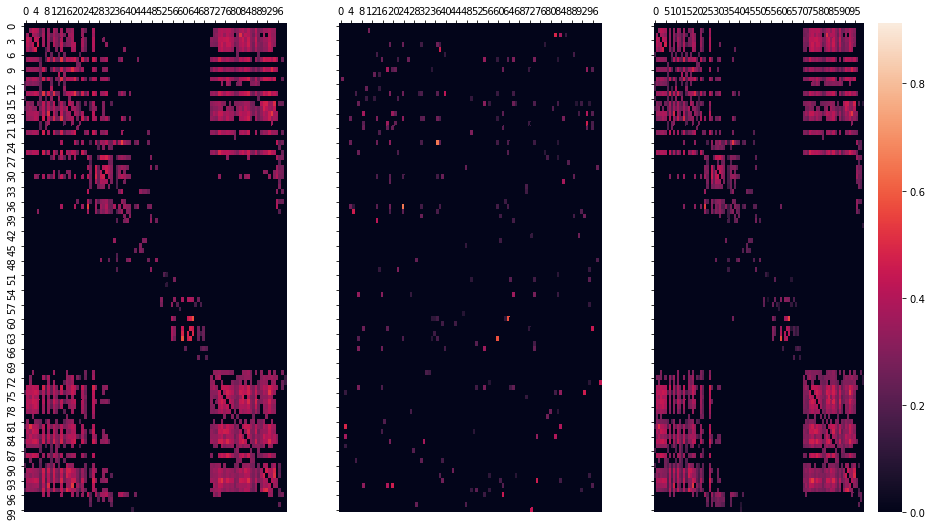

In [64]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

cf_sim_max = cf_sim.max()
cbf_sim_max = cbf_sim.max()
cfcbf_sim_max = cfcbf_sim.max()
vmax = np.max([cf_sim_max, cbf_sim_max, cfcbf_sim_max])

f, [ax1, ax2, ax3] = plt.subplots(1, 3, figsize=(16, 9), sharey=True)
sns.heatmap(cf_sim[:100, :100].todense(), cbar=False, vmin=0, vmax=vmax, ax=ax1)
sns.heatmap(cbf_sim[:100, :100].todense(), cbar=False, vmin=0, vmax=vmax, ax=ax2)
sns.heatmap(cfcbf_sim[:100, :100].todense(), cbar=True, vmin=0, vmax=vmax, ax=ax3)
ax1.xaxis.set_ticks_position("top")
ax2.xaxis.set_ticks_position("top")
ax3.xaxis.set_ticks_position("top")

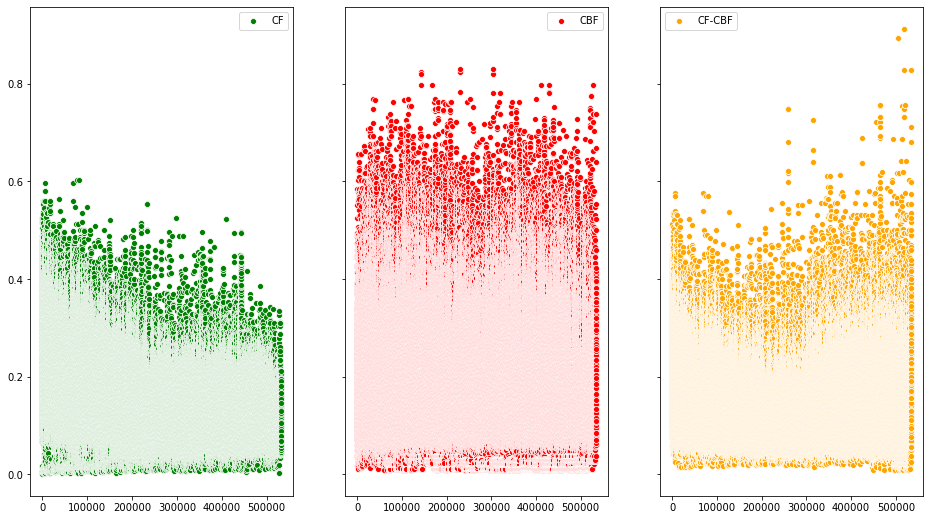

In [65]:
f, [ax1, ax2, ax3] = plt.subplots(1, 3, figsize=(16, 9), sharey=True)
sns.scatterplot(data=cf_sim.data, ax=ax1, color="green")
sns.scatterplot(data=cbf_sim.data, ax=ax2, color="red")
sns.scatterplot(data=cfcbf_sim.data, ax=ax3, color="orange")
ax1.legend(["CF"])
ax2.legend(["CBF"])
ax3.legend(["CF-CBF"])

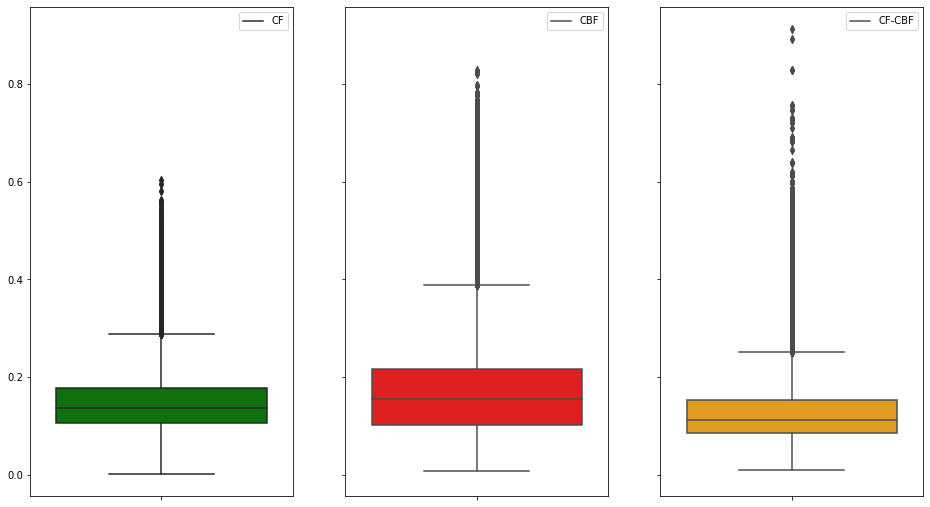

In [66]:
f, [ax1, ax2, ax3] = plt.subplots(1, 3, figsize=(16, 9), sharey=True)
sns.boxplot(x=cf_sim.data, orient="v", ax=ax1, color="green")
sns.boxplot(x=cbf_sim.data, orient="v", ax=ax2, color="red")
sns.boxplot(x=cfcbf_sim.data, orient="v", ax=ax3, color="orange")
ax1.legend(["CF"])
ax2.legend(["CBF"])
ax3.legend(["CF-CBF"])

Do you remember Bob (`user_id = 42`) and Toy Story (`item_id = 15`)?


In [67]:
cb_toy_story_sim = itemknn_cbf_recommender.W_sparse[15, :].todense().A.flatten()
cb_toy_story_sim

array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)

In [68]:
cf_toy_story_sim = itemKNNCF.W_sparse[15, :].todense().A.flatten()
cf_toy_story_sim

array([0.17453197, 0.        , 0.        , ..., 0.        , 0.        ,
       0.        ], dtype=float32)

In [69]:
cfcbf_toy_story_sim = itemknn_cf_cbf_w_recommender.W_sparse[15, :].todense().A.flatten()
cfcbf_toy_story_sim

array([0.15559725, 0.        , 0.        , ..., 0.        , 0.        ,
       0.        ], dtype=float32)

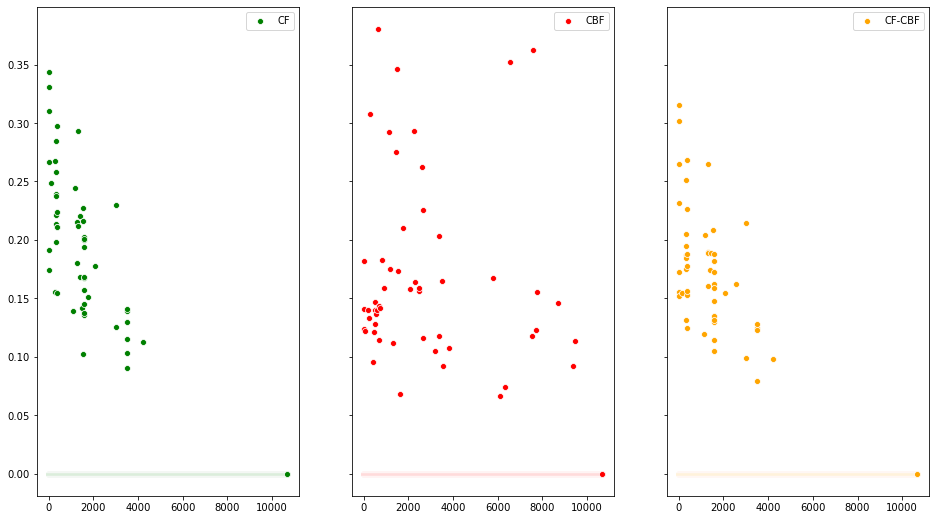

In [70]:
f, [ax1, ax2, ax3] = plt.subplots(1, 3, figsize=(16, 9), sharey=True)
sns.scatterplot(data=cf_toy_story_sim, ax=ax1, color="green")
sns.scatterplot(data=cb_toy_story_sim, ax=ax2, color="red")
sns.scatterplot(data=cfcbf_toy_story_sim, ax=ax3, color="orange")
ax1.legend(["CF"])
ax2.legend(["CBF"])
ax3.legend(["CF-CBF"])

In [71]:
cb_recs = itemknn_cbf_recommender.recommend(user_id_array=[42], cutoff=10, remove_seen_flag=True)
cb_recs = np.array(cb_recs).flatten()
cb_recs

array([ 381, 2315, 5165, 2960, 2113,   26, 5011, 2392, 5012, 2316])

In [72]:
cf_recs = itemKNNCF.recommend(user_id_array=[42], cutoff=10, remove_seen_flag=True)
cf_recs = np.array(cf_recs).flatten()
cf_recs

array([2003,  237, 1253, 2113, 2116, 2492,  158,  163, 2114,  232])

In [73]:
cbcbf_recs = itemknn_cf_cbf_w_recommender.recommend(user_id_array=[42], cutoff=10, remove_seen_flag=True)
cbcbf_recs = np.array(cbcbf_recs).flatten()
cbcbf_recs

array([2003,  237, 2113, 2116, 1253, 2492,  158,  146,  230,  163])

In [74]:
print(set(cb_recs).intersection(cf_recs))
print(set(cb_recs).intersection(cbcbf_recs))
print(set(cf_recs).intersection(cbcbf_recs))
print(set(cbcbf_recs) - set(cf_recs))

{2113}
{2113}
{2113, 163, 2116, 1253, 237, 2003, 2492, 158}
{146, 230}


### Quick Recap

We have seen an specific case of CF-CBF hybrid, where we join together the ICM and the URM used for training. We also inspected the similarities and recommendations of each model and the hybrid.

We can still create hybrids the way we did before, i.e., by merging their models (ItemKNN + P3Alpha), or their item scores (PureSVD + ItemKNN), even if their optimization functions are different (SLIMBPR + FunkSVD).

## User-wise hybrid

Models do not have the same accuracy for different user types. Let's divide the users according to their profile length and then compare the recommendation quality we get from a CF model.

Let's categorize user based on the number of interactions they have.

In [75]:
bob_profile_start = URM_train.indptr[42]
bob_profile_ends = URM_train.indptr[42+1]
print(bob_profile_start, bob_profile_ends, bob_profile_ends - bob_profile_start)

URM_train.indices[bob_profile_start:bob_profile_ends], URM_train.indices[bob_profile_start:bob_profile_ends].shape

3736 4006 270


(array([   7,   24,   34,   43,   44,   45,   51,   56,   97,  103,  107,
         123,  132,  133,  144,  145,  147,  148,  149,  150,  151,  154,
         155,  156,  159,  160,  166,  167,  169,  170,  171,  174,  176,
         182,  191,  192,  198,  217,  218,  219,  220,  221,  222,  223,
         224,  225,  226,  227,  231,  235,  236,  239,  245,  249,  250,
         251,  260,  264,  265,  268,  271,  273,  278,  337,  391,  394,
         395,  402,  403,  411,  417,  430,  468,  487,  489,  506,  516,
         523,  584,  605,  612,  625,  632,  731,  739,  744,  787,  793,
         795,  887,  994, 1008, 1026, 1028, 1041, 1046, 1049, 1054, 1057,
        1061, 1066, 1070, 1071, 1073, 1074, 1075, 1076, 1092, 1093, 1095,
        1098, 1184, 1186, 1187, 1199, 1251, 1252, 1281, 1292, 1305, 1310,
        1337, 1342, 1368, 1426, 1438, 1439, 1441, 1442, 1446, 1464, 1465,
        1466, 1475, 1480, 1545, 1664, 1736, 1743, 1819, 1824, 1903, 1951,
        1974, 1977, 1982, 2001, 2002, 

As we can see, the `indptr` array can be used to determine the number of elements each user has interacted with. We only need the difference between where their profile starts and where it ends (`bob_profile_ends - bob_profile_start`).

Let's calculate this for all users using the `np.ediff1d` function.

In [76]:
profile_length = np.ediff1d(URM_train.indptr)
profile_length, profile_length.shape

(array([ 16,  17,  20, ..., 112,  41,  33], dtype=int32), (69878,))

Let's select a few groups of 5% of the users with the least number of interactions.

In [77]:
block_size = int(len(profile_length)*0.05)
block_size

3493

In [78]:
sorted_users = np.argsort(profile_length)
sorted_users

array([ 6472, 36062, 36384, ..., 14085, 65888, 57959])

In [79]:
for group_id in range(0, 20):
    start_pos = group_id * block_size
    end_pos = min((group_id+1) * block_size, len(profile_length))
    
    users_in_group = sorted_users[start_pos:end_pos]
    
    users_in_group_p_len = profile_length[users_in_group]
    
    print("Group {}, #users in group {}, average p.len {:.2f}, median {}, min {}, max {}".format(
        group_id, 
        users_in_group.shape[0],
        users_in_group_p_len.mean(),
        np.median(users_in_group_p_len),
        users_in_group_p_len.min(),
        users_in_group_p_len.max()))
    

Group 0, #users in group 3493, average p.len 13.65, median 14.0, min 6, max 15
Group 1, #users in group 3493, average p.len 16.51, median 17.0, min 15, max 18
Group 2, #users in group 3493, average p.len 18.72, median 19.0, min 18, max 20
Group 3, #users in group 3493, average p.len 21.14, median 21.0, min 20, max 23
Group 4, #users in group 3493, average p.len 24.03, median 24.0, min 23, max 26
Group 5, #users in group 3493, average p.len 27.29, median 27.0, min 26, max 29
Group 6, #users in group 3493, average p.len 31.10, median 31.0, min 29, max 33
Group 7, #users in group 3493, average p.len 35.50, median 35.0, min 33, max 38
Group 8, #users in group 3493, average p.len 40.44, median 40.0, min 38, max 43
Group 9, #users in group 3493, average p.len 46.28, median 46.0, min 43, max 50
Group 10, #users in group 3493, average p.len 53.58, median 54.0, min 50, max 58
Group 11, #users in group 3493, average p.len 62.60, median 62.0, min 58, max 68
Group 12, #users in group 3493, average

Now let's calculate the evaluation metrics of each recommender when considering groups of users.

In [80]:
from Base.NonPersonalizedRecommender import TopPop

top_pop = TopPop(URM_train)
top_pop.fit()

TopPopRecommender: URM Detected 51 (0.48 %) cold items.


In [88]:
MAP_recommender_per_group = {}

recommenders = [("TopPop", top_pop),
                ("ItemKNNCF", itemKNNCF),
                ("P3alpha", P3alpha),
                ("PureSVD", pureSVD),
                ("FunkSVD", funk_svd_recommender),
                ("SLIMBPR", slim_bpr_recommender),
                ("ItemKNNCBF", itemknn_cbf_recommender),
                ("ItemKNNCF + P3alpha", hybridrecommender),
                ("ItemKNNCF + PureSVD", scoreshybridrecommender),
                ("FunkSVD + SLIMBPR", difflossscoreshybridrecommender),
                ("ItemKNNCFCBF", itemknn_cf_cbf_w_recommender),
                ]
cutoff = 10

for group_id in range(0, 20):
    
    start_pos = group_id*block_size
    end_pos = min((group_id+1)*block_size, len(profile_length))
    
    users_in_group = sorted_users[start_pos:end_pos]
    
    users_in_group_p_len = profile_length[users_in_group]
    
    print("Group {}, #users in group {}, average p.len {:.2f}, median {}, min {}, max {}".format(
        group_id, 
        users_in_group.shape[0],
        users_in_group_p_len.mean(),
        np.median(users_in_group_p_len),
        users_in_group_p_len.min(),
        users_in_group_p_len.max()))
    
    
    users_not_in_group_flag = np.isin(sorted_users, users_in_group, invert=True)
    users_not_in_group = sorted_users[users_not_in_group_flag]
    
    evaluator_test = EvaluatorHoldout(URM_test, cutoff_list=[cutoff], ignore_users=users_not_in_group)
    
    for label, recommender in recommenders:
        results, _ = evaluator_test.evaluateRecommender(recommender)
        if label in MAP_recommender_per_group:
            MAP_recommender_per_group[label].append(results[cutoff]["MAP"])
        else:
            MAP_recommender_per_group[label] = [results[cutoff]["MAP"]]
        

Group 0, #users in group 3493, average p.len 13.65, median 14.0, min 6, max 15
EvaluatorHoldout: Ignoring 66385 Users
EvaluatorHoldout: Processed 3492 ( 100.00% ) in 1.53 sec. Users per second: 2282
EvaluatorHoldout: Processed 3492 ( 100.00% ) in 1.74 sec. Users per second: 2006
EvaluatorHoldout: Processed 3492 ( 100.00% ) in 1.65 sec. Users per second: 2122
EvaluatorHoldout: Processed 3492 ( 100.00% ) in 1.95 sec. Users per second: 1787
EvaluatorHoldout: Processed 3492 ( 100.00% ) in 2.00 sec. Users per second: 1745
EvaluatorHoldout: Processed 3492 ( 100.00% ) in 1.58 sec. Users per second: 2203
EvaluatorHoldout: Processed 3492 ( 100.00% ) in 1.55 sec. Users per second: 2252
EvaluatorHoldout: Processed 3492 ( 100.00% ) in 1.57 sec. Users per second: 2223
EvaluatorHoldout: Processed 3492 ( 100.00% ) in 1.97 sec. Users per second: 1770
EvaluatorHoldout: Processed 3492 ( 100.00% ) in 2.41 sec. Users per second: 1446
EvaluatorHoldout: Processed 3492 ( 100.00% ) in 1.59 sec. Users per seco

EvaluatorHoldout: Processed 3493 ( 100.00% ) in 1.59 sec. Users per second: 2191
EvaluatorHoldout: Processed 3493 ( 100.00% ) in 1.67 sec. Users per second: 2092
EvaluatorHoldout: Processed 3493 ( 100.00% ) in 1.47 sec. Users per second: 2384
EvaluatorHoldout: Processed 3493 ( 100.00% ) in 1.77 sec. Users per second: 1974
EvaluatorHoldout: Processed 3493 ( 100.00% ) in 1.93 sec. Users per second: 1812
EvaluatorHoldout: Processed 3493 ( 100.00% ) in 1.70 sec. Users per second: 2060
EvaluatorHoldout: Processed 3493 ( 100.00% ) in 1.67 sec. Users per second: 2097
EvaluatorHoldout: Processed 3493 ( 100.00% ) in 1.71 sec. Users per second: 2047
EvaluatorHoldout: Processed 3493 ( 100.00% ) in 2.02 sec. Users per second: 1728
EvaluatorHoldout: Processed 3493 ( 100.00% ) in 2.51 sec. Users per second: 1392
EvaluatorHoldout: Processed 3493 ( 100.00% ) in 1.75 sec. Users per second: 1991
Group 9, #users in group 3493, average p.len 46.28, median 46.0, min 43, max 50
EvaluatorHoldout: Ignoring 66

EvaluatorHoldout: Processed 3493 ( 100.00% ) in 1.59 sec. Users per second: 2195
EvaluatorHoldout: Processed 3493 ( 100.00% ) in 1.81 sec. Users per second: 1932
EvaluatorHoldout: Processed 3493 ( 100.00% ) in 2.01 sec. Users per second: 1734
EvaluatorHoldout: Processed 3493 ( 100.00% ) in 2.02 sec. Users per second: 1730
EvaluatorHoldout: Processed 3493 ( 100.00% ) in 2.02 sec. Users per second: 1725
EvaluatorHoldout: Processed 3493 ( 100.00% ) in 2.06 sec. Users per second: 1694
EvaluatorHoldout: Processed 3493 ( 100.00% ) in 2.34 sec. Users per second: 1491
EvaluatorHoldout: Processed 3493 ( 100.00% ) in 2.80 sec. Users per second: 1249
EvaluatorHoldout: Processed 3493 ( 100.00% ) in 2.08 sec. Users per second: 1682
Group 17, #users in group 3493, average p.len 206.88, median 206.0, min 178, max 241
EvaluatorHoldout: Ignoring 66385 Users
EvaluatorHoldout: Processed 3493 ( 100.00% ) in 1.71 sec. Users per second: 2046
EvaluatorHoldout: Processed 3493 ( 100.00% ) in 2.23 sec. Users pe

{'TopPop': [0.04418421392834849, 0.04908800837303047, 0.0512640200764557, 0.05502591622846842, 0.0552663829432624, 0.054162490044331484, 0.05448342459040368, 0.0567463567851247, 0.05621587508782812, 0.06199656331343179, 0.06165113529798686, 0.07350542674630482, 0.08185633297332899, 0.08953013737225039, 0.09959462007916084, 0.11497960774156028, 0.13522708682671442, 0.16464289122462608, 0.20600374217823395, 0.3125900440336459], 'ItemKNNCF': [0.12320449391467982, 0.1259395835327141, 0.1288684006989416, 0.13447302248903803, 0.1361790443280386, 0.1418152487432707, 0.13201424599314482, 0.13885960615756923, 0.1356808194458242, 0.14085355306408795, 0.14688247792781706, 0.1635678296989184, 0.1732469076474944, 0.18684456214015271, 0.20150474418224135, 0.2261815013246449, 0.25580907847440876, 0.29294041597935144, 0.3451212515734425, 0.4334248088012779], 'P3alpha': [0.12354065284953226, 0.12576748728861692, 0.13076636944412726, 0.13809692586067174, 0.13208792565473132, 0.13078231238341403, 0.12392

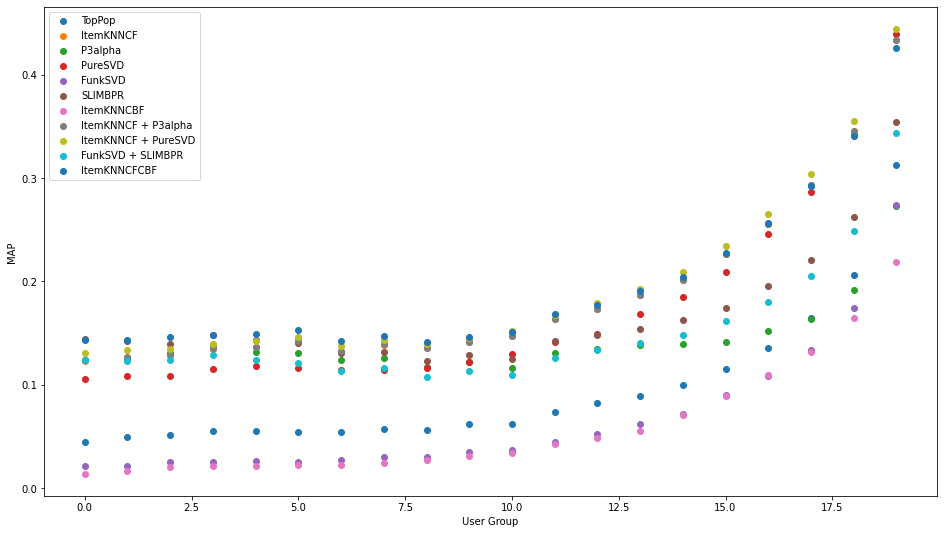

In [89]:
import matplotlib.pyplot as plt
%matplotlib inline  

_ = plt.figure(figsize=(16, 9))
for label, recommender in recommenders:
    results = MAP_recommender_per_group[label]
    plt.scatter(x=np.arange(0,len(results)), y=results, label=label)
plt.ylabel('MAP')
plt.xlabel('User Group')
plt.legend()
plt.show()

### The recommendation quality of the three algorithms changes depending on the user profile length

## Tip:
### If an algorithm works best on average, it does not imply it will work best for ALL user types